#### Pourquoi les signaux démodulés Lagrangien n'ont-ils rien à voir avec ceux interpolés sur les trajectoires à partir des données Eulériennes???

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp
import pyinterp

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7675256.datarmor0/parcels-502090/libparcels_random_a8b16986-e57b-434a-9556-341f6114488d.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=2
                 )
#
client = Client(cluster)

In [3]:
isel = dict(face=7)
sel = dict(i=slice(2700,2900), j=slice(2900,3100))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
#sel = dict(i=[3000,3010], j=[3000,3010], i_g=[3000,3010], j_g=[3000,3010]) # North East Hawaii

In [4]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [5]:
ds = xr.merge([xr.open_zarr(ut.work_data_dir+'rechunked/SSU.zarr'),xr.open_zarr(ut.work_data_dir+'rechunked/SSV.zarr'),
               xr.open_zarr(ut.work_data_dir+'rechunked/Eta.zarr')
              ])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

In [6]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

In [7]:
dsp = ds.isel(**isel).sel(**sel)

dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10
dsp

<xarray.Dataset>
Dimensions:  (i: 101, j: 101, time: 8784)
Coordinates:
  * i        (i) int64 2700 2702 2704 2706 2708 ... 2892 2894 2896 2898 2900
  * j        (j) int64 2900 2902 2904 2906 2908 ... 3092 3094 3096 3098 3100
    face     int64 7
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-14T23:00:00
    XC       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(8784, 86, 90), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>

In [8]:
dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat})
dsp = dsp.drop(['SSU','SSV']).persist()



In [9]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [10]:
def wrap_filter(_ds,om,Tw,dband,V,dt=dt):
    h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*omega*2*np.pi*time)
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True).persist()
        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real']=ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag']=ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])
    return ds_hat,h
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'T_window':T_window,'bandwidth':[b*2 for b in bandwidths]})

In [11]:
V = ['zonal_velocity','meridional_velocity'
    ]
Tw = 30
dband=0.2 #half bandwidth

In [12]:
ds_hat,h = wrap_filter(dsp,omega,Tw,dband,V)

In [36]:
ds_hat = xr.merge([ds_hat,dsp])

In [13]:
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


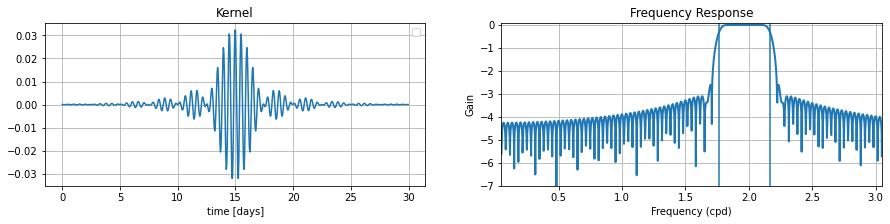

In [14]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
    #t = np.arange(0, h.size)*dt
t = np.arange(0, h.size)*dt
ax.plot(t, h);
ax.grid();
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()
ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband)#, color='k')
ax.axvline(omega+dband)#, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)
    #H.plot.line(hue='T_window')

### Drifters

In [15]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'time'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
lonmin,lonmax,latmin,latmax = dsp.lon.min().values,dsp.lon.max().values,dsp.lat.min().values,dsp.lat.max().values

In [17]:
# extract relevant trajectory indices
bbox=[lonmin,lonmax,latmin,latmax]
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
#traj = _df.index.drop_duplicates(keep='first').compute()#["index"]

df_selected = df[df.trajectory.isin(traj)]

In [18]:
def filt_L(v, h,columns, hilbert=False):
    vc = v.copy()
    for V in columns:
        vc[V+'_hat'] = convolve(vc[V],h,hilbert=hilbert)
    time = np.arange(0,vc.index.size*dt,dt)#.compute()
    exp = np.exp(-1j*omega*2*np.pi*time)
    for V in columns:
        vc[V+'_demodulated'] = vc[V+'_hat']*exp
    return vc

In [19]:
Tw = Tw
dband= dband
omega = omega #(omega_M2+omega_S2)/2
hL = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)


In [20]:
#h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
df_selected = df_selected.drop_duplicates().reset_index().sort_values('time').set_index('time')
df_filtered = df_selected.groupby('trajectory').apply(filt_L,hL,['zonal_velocity','meridional_velocity'],hilbert=True).persist()
df_filtered = df_filtered.repartition(npartitions=10).persist()

<ipython-input-20-0c2bd623a066>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = df_selected.groupby('trajectory').apply(filt_L,hL,['zonal_velocity','meridional_velocity'],hilbert=True).persist()


In [21]:
df_filtered = df_filtered.drop(columns='trajectory').reset_index().sort_values('time').set_index('time').persist()

In [22]:
dt = 1/24
t_mid = int(366/dt//2)
dtime = int(5/dt)

In [159]:
dsi = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime)))
_df1 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==37000174].compute()
_df2 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000248].compute()
_df3 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38001401].compute()
_df4 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000024].compute()
_df5 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000172].compute()
_df6 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000097].compute()

In [160]:
print(dsi.time.values.size,_df1.index.size)
print(dsi.time.values.size,_df2.index.size)

240 242
240 243


In [161]:
#for _f in [_df1,_df2,_df3,_df4,_df5,_df5]:
_df1 = _df1.reset_index().drop_duplicates(subset='time').set_index('time')
_df2 = _df2.reset_index().drop_duplicates(subset='time').set_index('time')
_df3 = _df3.reset_index().drop_duplicates(subset='time').set_index('time')
_df4 = _df4.reset_index().drop_duplicates(subset='time').set_index('time')
_df5 = _df5.reset_index().drop_duplicates(subset='time').set_index('time')
_df6 = _df6.reset_index().drop_duplicates(subset='time').set_index('time')
#dfi_2 = dfi_2.reset_index().drop_duplicates(subset='time').set_index('time')

In [162]:
print(dsi.time.values.size,_df1.index.size)
print(dsi.time.values.size,_df2.index.size)

240 240
240 240


In [163]:
time = _df2.index

In [164]:
df_mid = _df2.loc[time[time.size//2]]
#df_mid = dfi.loc[time[time.size//2]]
df_mid_2 = _df1.loc[time[time.size//2]]

In [165]:
eps = 0.01
ds_mid = dsi.where((dsi.lon<=df_mid.lon+eps)&(dsi.lon>=df_mid.lon-eps)&
                                                   (dsi.lat<=df_mid.lat+eps)&(dsi.lat>=df_mid.lat-eps),drop=True)#.sel(time=time[time.size//2])
ds_mid_2 = dsi.where((dsi.lon<=df_mid_2.lon+eps)&(dsi.lon>=df_mid_2.lon-eps)&
                                                   (dsi.lat<=df_mid_2.lat+eps)&(dsi.lat>=df_mid_2.lat-eps),drop=True)#.sel(time=time[time.size//2])

In [175]:
def interp_sig(_df, v,time,part=None):
    idw_eta, neighbors = [],[]
    idw_eta_mid, neighbors_mid = [],[]
    
    for it in range(0,_df2.index.values.size):
    #for t in time
        mesh = pyinterp.RTree()
        _dsi = dsi.isel(time=it)#
        if part=='real':
            var = np.real(_dsi[v].values)
        elif part=='imag':
            var = np.imag(_dsi[v].values)
        else:
            var = _dsi[v].values
        mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                                _dsi.YC.values.flatten())).T,
                         var.flatten(),
                        )

        idw_eta.append(mesh.inverse_distance_weighting(
                np.vstack((_df.lon[it], _df.lat[it])).T,
                within=True,
                radius=5e5,
                k=4,  
                num_threads=0)[0])
        neighbors.append(mesh.inverse_distance_weighting(
                np.vstack((_df.lon[it], _df.lat[it])).T,
                within=True,
                radius=5e5,
                k=4,  
                num_threads=0)[1])
        idw_eta_mid.append(mesh.inverse_distance_weighting(
                np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                within=True,
                radius=5e5,
                k=4,  
                num_threads=0)[0])
        neighbors_mid.append(mesh.inverse_distance_weighting(
                np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                within=True,
                radius=5e5,
                k=4,  
                num_threads=0)[1])
    interp = idw_eta[0]
    for i in idw_eta[1:]:
        interp = np.insert(i,-1,interp)
    interp_mid = idw_eta_mid[0]
    for i in idw_eta_mid[1:]:
        interp_mid = np.insert(i,-1,interp_mid)
    return interp, interp_mid

In [60]:
def gen_figs_flts_interp(_df,idw_eta,it,v,dt,savefig=False):
    name=v+'_%s'%it
    _s = dsi.isel(time=it)
    t = _s.time.values
    fig,axs= plt.subplots(2,2,figsize=(10,10))
#    fig = plt.figure(figsize=(10,10),constrained_layout=True)
#    gs = gridspec.GridSpec(2, 2, figure=fig)
#    ax = fig.add_subplot(gs[0, 0],sharey=True)
    ax= axs[0,0]
    _s[v+'_demodulated'].real.plot(ax=ax,x='lon',y='lat',vmax=0.2,add_colorbar=False,cmap='RdBu_r')
                                                  #,cbar_kwargs={'label':'Demodulated '+v+' : real part'})
    if it>= 3/dt:
        t0 = t-np.timedelta64(3,'D')
    else:
        t0= dsi.isel(time=0).time.values
    #ax.scatter(_df[1].lon,_df[1].lat,c='grey',marker='.',s=1,alpha=0.3)    
    ax.scatter(_df[1].loc[t0:t].lon,_df[1].loc[t0:t].lat,c='darkred',s=3)    
    for _f in [_df1,_df3,_df4,_df5,_df6]:
        ax.scatter(_f.loc[t0:t].lon,_f.loc[t0:t].lat,marker='.',c='k',s=3)   
    for _f in _df:
        ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.1)    
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=10)
    ax.scatter(ds_mid[v+'_demodulated'].lon.values,ds_mid[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : real part');#ax.set_aspect('equal');
    ax=axs[0,1]
    cs = dsi[v+'_demodulated'].imag.isel(time=it).plot(ax=ax,x='lon',y='lat',vmax=0.2,add_colorbar=False)
                                                 # ,cbar_kwargs={'label':'Demodulated velocity'})
    #ax.scatter(_df[1].lon,_df[1].lat,c='grey',marker='.',s=1,alpha=0.3)    
    ax.scatter(_df[1].loc[t0:t].lon,_df[1].loc[t0:t].lat,c='darkred',s=3)    
    for _f in [_df1,_df3,_df4,_df5,_df6]:
        ax.scatter(_f.loc[t0:t].lon,_f.loc[t0:t].lat,marker='.',c='k',s=3)    
    for _f in _df:
        ax.scatter(_f.lon,_f.lat,c='grey',marker='.',s=1,alpha=0.1)    
        ax.scatter(_f.loc[t].lon,_f.loc[t].lat,c='r',s=10)
    ax.scatter(ds_mid[v+'_demodulated'].lon.values,ds_mid[v+'_demodulated'].lat.values,c='lightseagreen',marker='d')
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax);
    ax.set_title('Demodulated '+v+' : imaginary part');#ax.set_aspect('equal')
    ax= axs[1,0]
    #_df[1][v+'_demodulated_real_interp'].plot(ax=ax,c='grey',linestyle='--',linewidth=1)
    ax.plot(time,_df[1][v+'_demodulated'].apply(lambda x: np.real(x)),c='firebrick')#.plot(ax=ax,c='firebrick')
    #_df[1][v+'_demodulated'].apply(lambda x: np.real(x)).plot(ax=ax,c='firebrick');
    ax.plot(time,idw_eta[2],c='lightseagreen')
    ax.plot(time,idw_eta[0],c='grey',linestyle='--',linewidth=1)
    #_dsi[v+'_demodulated'].real.plot(ax=ax,c='lightseagreen');
    ax.axvline(dsi.isel(time=time.size//2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
    ax.grid();ax.axvline(dsi.isel(time=it).time.values,c='k');ax.set_ylabel('Velocity');ax.set_ylim(-0.2,0.2)
    #ax.set_title('Demodulated '+v+' : real part')
    ax= axs[1,1]
    #_df[1][v+'_demodulated_imag_interp'].plot(ax=ax,c='grey',linestyle='--',linewidth=1)
    ax.plot(time,_df[1][v+'_demodulated'].apply(lambda x: np.imag(x)),c='firebrick')#.plot(ax=ax,c='firebrick')
    ax.plot(time,idw_eta[3],c='lightseagreen')
    ax.plot(time,idw_eta[1],c='grey',linestyle='--',linewidth=1)
#    _dsi[v+'_demodulated'].imag.plot(ax=ax,c='lightseagreen')
    ax.axvline(dsi.isel(time=time.size//2).time.values,c='lightseagreen',linestyle='--',linewidth=1);
    ax.grid();ax.axvline(t,c='k');
    ax.set_ylabel('');ax.set_ylim(-0.15,0.15)
    #ax.set_title('Demodulated '+v+' : imaginary part')
    for a in axs[1,:]:
        a.set_title('')
    fig.suptitle('Time : %s'%_s[v+'_demodulated'].time.values.astype('M8[s]'))
    cax = plt.axes([1.01, .54, 0.02, 0.4])
#plt.colorbar(cax=cax)
    fig.colorbar(cs,cax=cax)
    fig.tight_layout()
    if savefig:
#        plt.show()
        fig.savefig('/home1/datawork/zcaspar/Figs/demodulated_flts/'+name+'.jpg')
        plt.close()

#### Unfiltered signal (time window = 10 days)

In [180]:
v = 'zonal_velocity'
interp_u,interp_u_mid = interp_sig(_df2,v,_df2.index.values)
interp2_u,interp_u_mid2 = interp_sig(_df1,v,_df1.index.values)

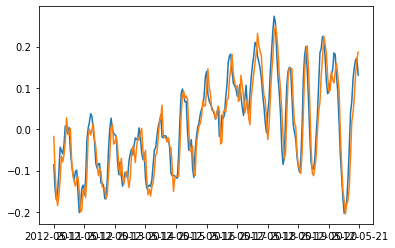

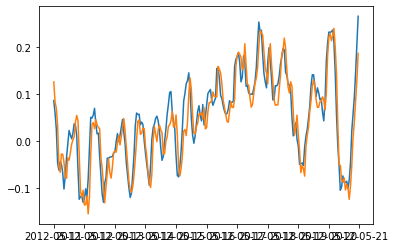

In [206]:
plt.plot(_df2.index.values,interp_u)
plt.plot(_df2.index.values,_df2.zonal_velocity)
plt.figure()
plt.plot(_df1.index.values,interp2_u)
plt.plot(_df1.index.values,_df1.zonal_velocity)

In [183]:
print(_df2.index.values[0], ' : ', _df2.zonal_velocity.values[0])
print(dsi.sel(time=_df2.index.values[0]).time.values,' : ', interp_u[0])


2012-05-11T00:00:00.000000000  :  -0.017711363541839154
2012-05-11T00:00:00.000000000  :  -0.08605416819736858


In [184]:
_dsi = dsi.isel(time=0)
var = _dsi.zonal_velocity.values
mesh = pyinterp.RTree()
mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                                _dsi.YC.values.flatten())).T,
                         var.flatten(),
                        )

idw_eta=mesh.inverse_distance_weighting(
                np.vstack((_df2.lon[0], _df2.lat[0])).T,
                within=True,
                radius=None,
                k=8,  
                num_threads=0)

In [185]:
print(_df2.zonal_velocity[0],idw_eta[0])

-0.017711363541839154 [-0.08903419]


In [186]:
print('Time Eulerian : ', _dsi.time.values)
print('Time Lagrangian',_df2.index.values[0])

Time Eulerian :  2012-05-11T00:00:00.000000000
Time Lagrangian 2012-05-11T00:00:00.000000000


(-155.0, -154.5)

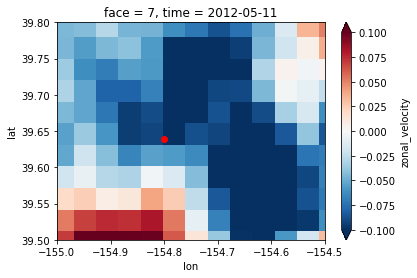

In [189]:
fig,ax = plt.subplots()
_dsi.zonal_velocity.plot(ax=ax,x='lon',y='lat',vmax=0.1)
ax.scatter(_df2.lon[0],_df2.lat[0],c='r')
ax.set_ylim(39.5,39.8);ax.set_xlim(-155,-154.5)

In [176]:
v = 'zonal_velocity_demodulated_real'
interp_demodr,interp_mid_demodr = interp_sig(_df2,v,_df2.index.values)
interp2_demodr,interp_mid2_demodr = interp_sig(_df1,v,_df1.index.values)



In [177]:
v = 'zonal_velocity_hat'
interp_hatr,interp_mid_hatr = interp_sig(_df2,v,_df2.index.values,part='real')
interp2_hatr,interp_mid2_hatr = interp_sig(_df1,v,_df1.index.values,part='real')

In [178]:
v = 'zonal_velocity_demodulated_imag'
interp_demodi,interp_mid_demodi = interp_sig(_df2,v,_df2.index.values)
interp2_demodi,interp_mid2_demodi = interp_sig(_df1,v,_df1.index.values)

In [179]:
v = 'zonal_velocity_hat'
interp_hati,interp_mid_hati = interp_sig(_df2,v,_df2.index.values,part='imag')
interp2_hati,interp_mid2_hati = interp_sig(_df1,v,_df1.index.values,part='imag')

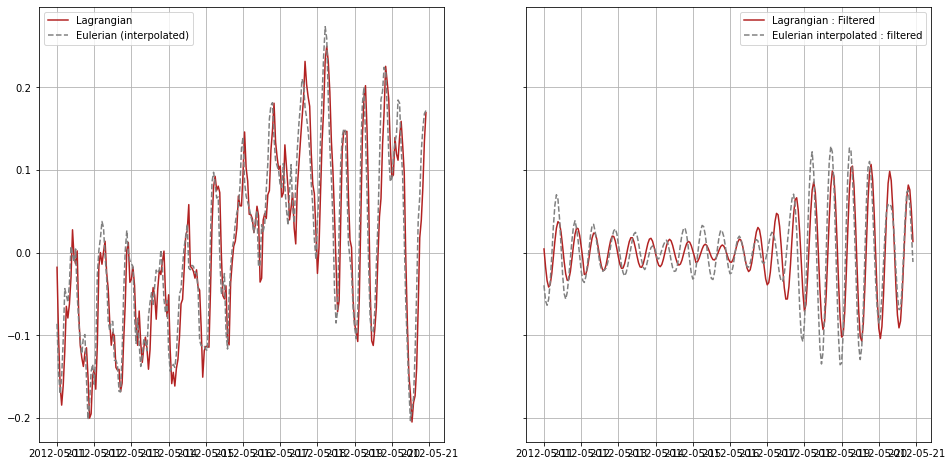

In [204]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
#ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time[:-1],np.real(_df2.zonal_velocity)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time[:-1],interp_u[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[1].plot(time[:-1],np.real(_df2.zonal_velocity_hat)[:-1],c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time[:-1],interp_hatr[:-1],c='grey',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
#ax[0].set_title('Real part')

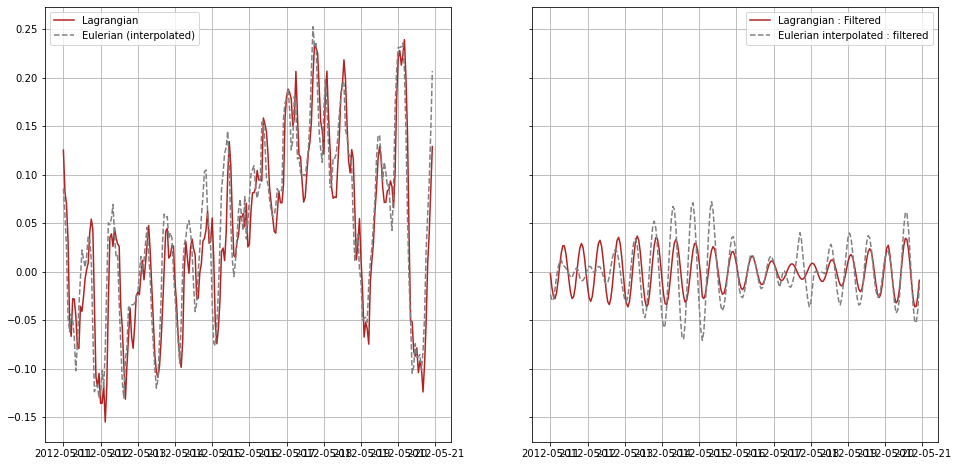

In [205]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
#ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time[:-1],np.real(_df1.zonal_velocity)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time[:-1],interp2_u[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[1].plot(time[:-1],np.real(_df1.zonal_velocity_hat)[:-1],c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time[:-1],interp2_hatr[:-1],c='grey',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()

Text(0.5, 1.0, 'Interpolated Eulerian : imaginary part')

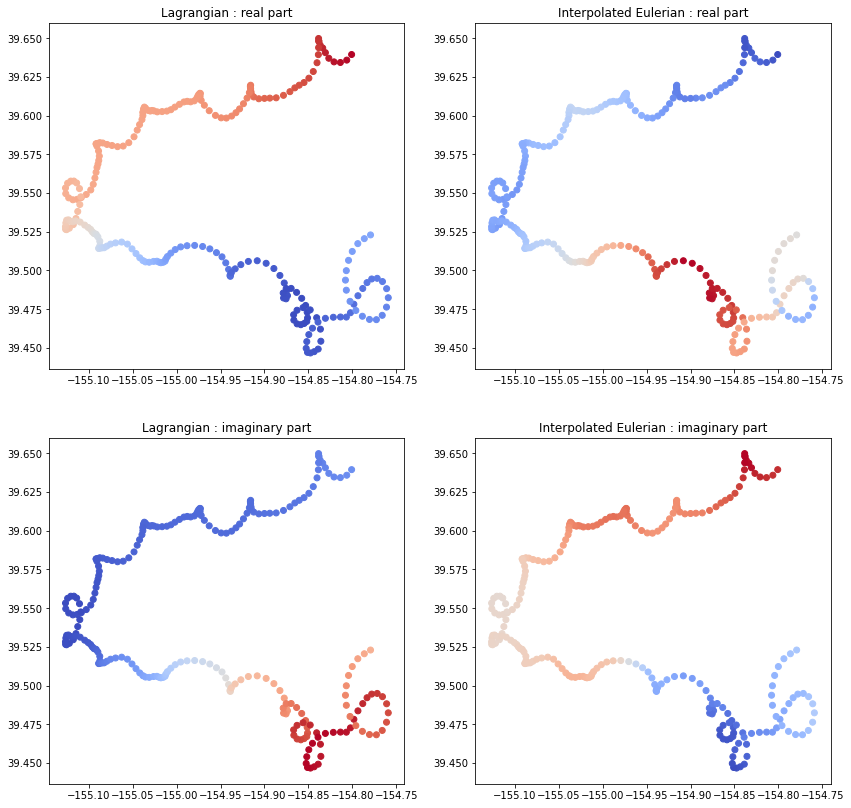

In [191]:
fig,ax = plt.subplots(2,2,figsize=(14,14))
ax[0,0].scatter(_df2.lon,_df2.lat,c=np.real(_df2.zonal_velocity_demodulated),cmap='coolwarm');
ax[0,1].scatter(_df2.lon,_df2.lat,c=interp_demodr,cmap='coolwarm');
#ax[0].scatter(dfi_2.lon,dfi_2.lat,s=1,c=np.real(dfi_2.zonal_velocity_demodulated))
ax[1,0].scatter(_df2.lon,_df2.lat,c=np.imag(_df2.zonal_velocity_demodulated),cmap='coolwarm');
ax[1,1].scatter(_df2.lon,_df2.lat,c=interp_demodi,cmap='coolwarm');
ax[0,0].set_title('Lagrangian : real part');ax[0,1].set_title('Interpolated Eulerian : real part')
ax[1,0].set_title('Lagrangian : imaginary part');ax[1,1].set_title('Interpolated Eulerian : imaginary part')


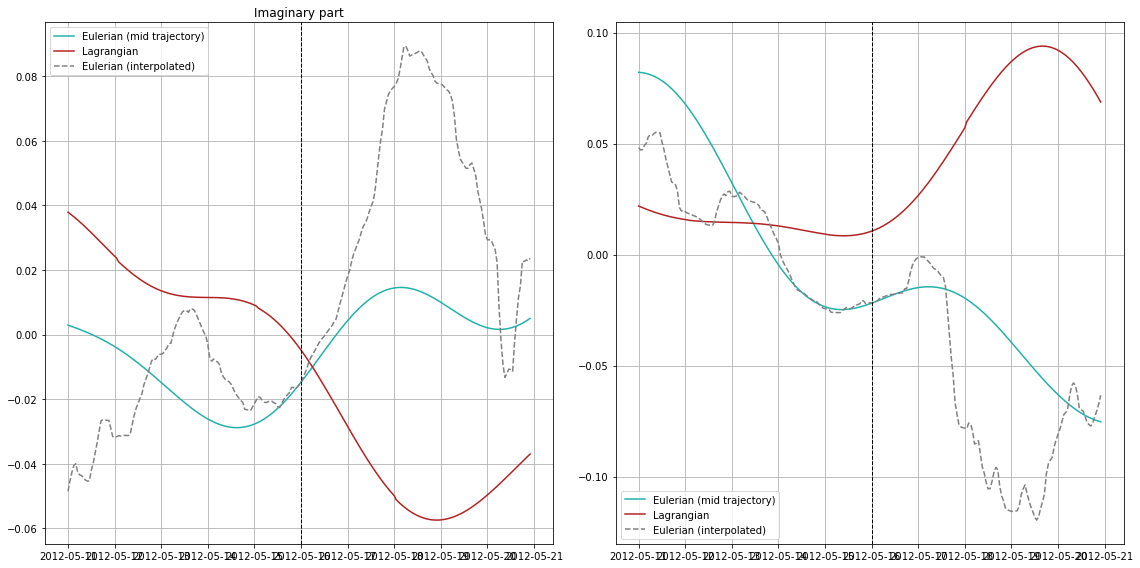

In [193]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time[:-1],np.real(_df2.zonal_velocity_demodulated)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time[:-1],interp_demodr[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[0].legend();ax[0].grid()
ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Real part')
ax[1].plot(time[:-1],interp_mid_demodi[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[1].plot(time[:-1],np.imag(_df2.zonal_velocity_demodulated)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[1].plot(time[:-1],interp_demodi[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[1].legend();ax[1].grid()
ax[1].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Imaginary part')
fig.tight_layout()

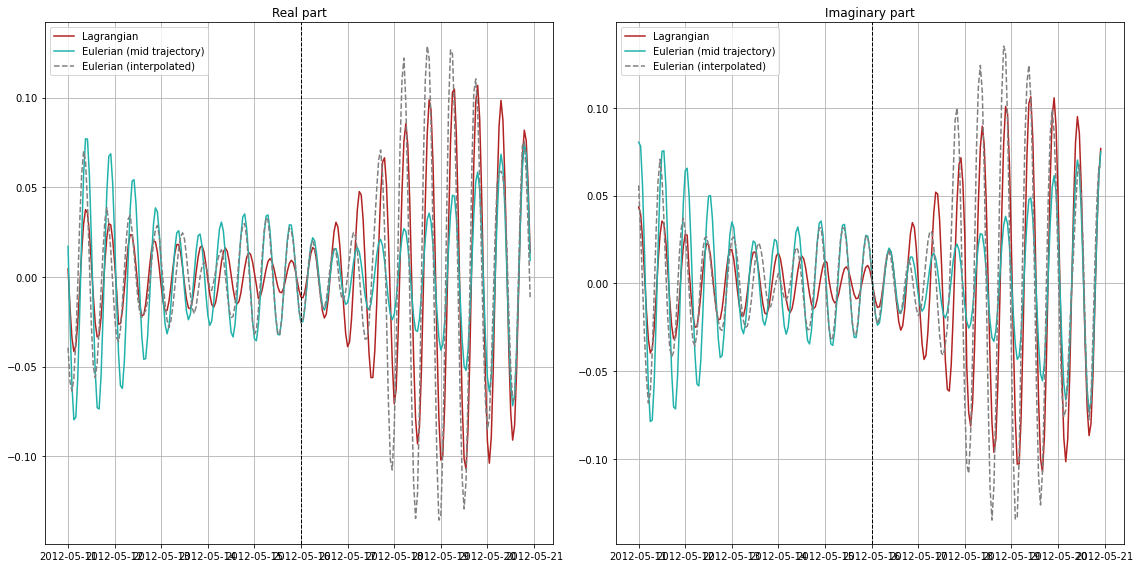

In [194]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(time[:-1],np.real(_df2.zonal_velocity_hat)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time[:-1],interp_mid_hatr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time[:-1],interp_hatr[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[0].legend();ax[0].grid()
ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Real part')

ax[1].plot(time[:-1],np.imag(_df2.zonal_velocity_hat)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[1].plot(time[:-1],interp_mid_hati[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[1].plot(time[:-1],interp_hati[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[1].legend();ax[1].grid()
ax[1].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].set_title('Imaginary part')
fig.tight_layout()

Text(0.5, 1.0, 'Interpolated Eulerian : imaginary part')

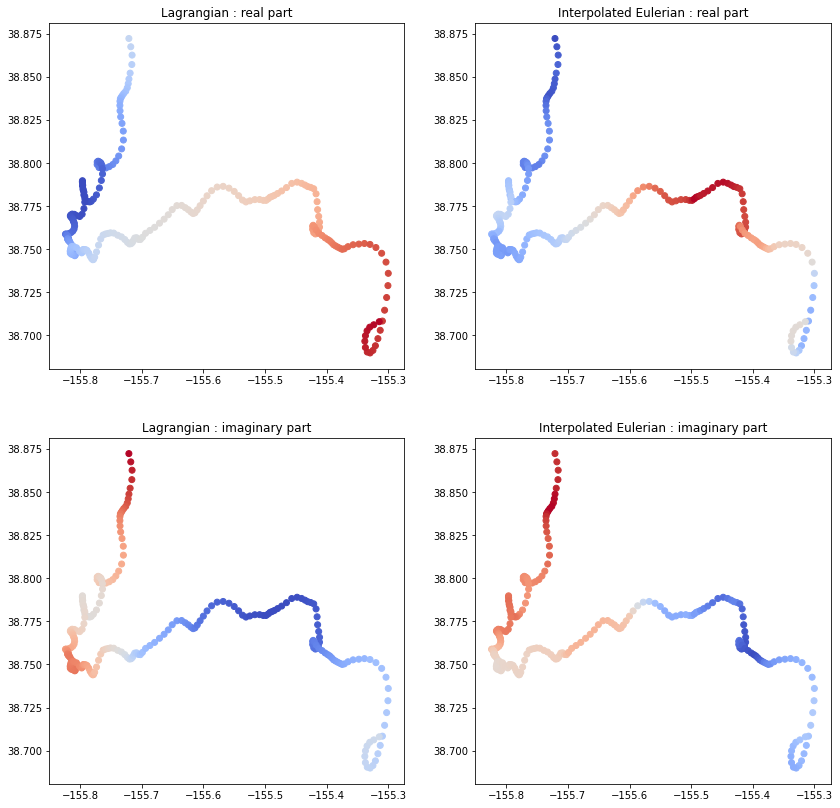

In [192]:
fig,ax = plt.subplots(2,2,figsize=(14,14))
ax[0,0].scatter(_df1.lon,_df1.lat,c=np.real(_df1.zonal_velocity_demodulated),cmap='coolwarm');
ax[0,1].scatter(_df1.lon,_df1.lat,c=interp_demodr,cmap='coolwarm');
ax[0,0].set_title('Lagrangian : real part');ax[0,1].set_title('Interpolated Eulerian : real part')
#ax[0].scatter(dfi_2.lon,dfi_2.lat,s=1,c=np.real(dfi_2.zonal_velocity_demodulated))
ax[1,0].scatter(_df1.lon,_df1.lat,c=np.imag(_df1.zonal_velocity_demodulated),cmap='coolwarm');
ax[1,1].scatter(_df1.lon,_df1.lat,c=interp_demodi,cmap='coolwarm');
ax[1,0].set_title('Lagrangian : imaginary part');ax[1,1].set_title('Interpolated Eulerian : imaginary part')


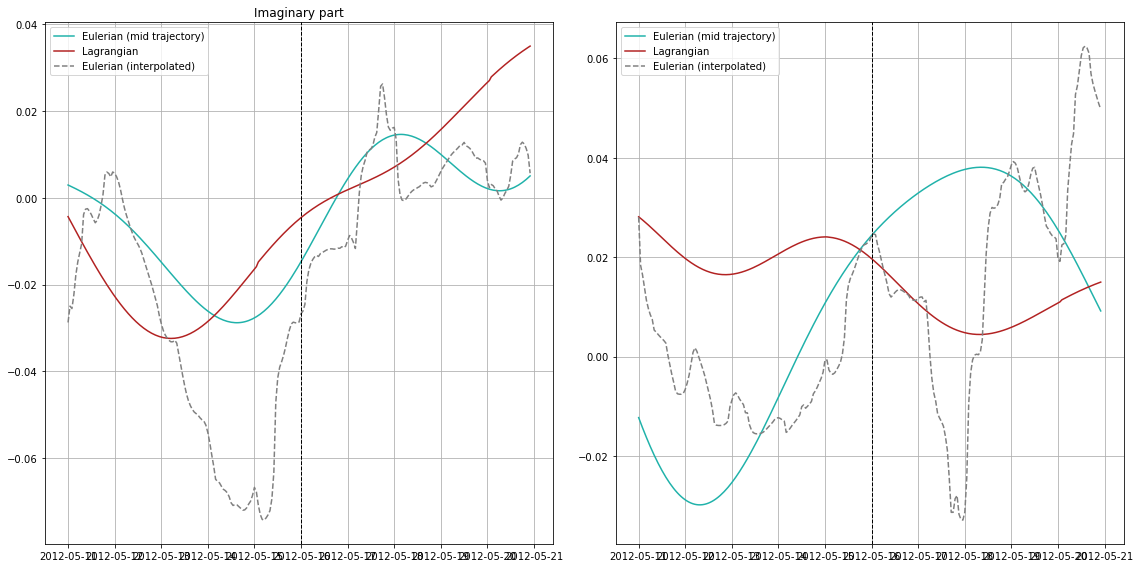

In [196]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(time[:-1],interp_mid_demodr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time[:-1],np.real(_df1.zonal_velocity_demodulated)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time[:-1],interp2_demodr[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[0].legend();ax[0].grid()
ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Real part')
ax[1].plot(time[:-1],interp_mid2_demodi[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[1].plot(time[:-1],np.imag(_df1.zonal_velocity_demodulated)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[1].plot(time[:-1],interp2_demodi[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[1].legend();ax[1].grid()
ax[1].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Imaginary part')
fig.tight_layout()

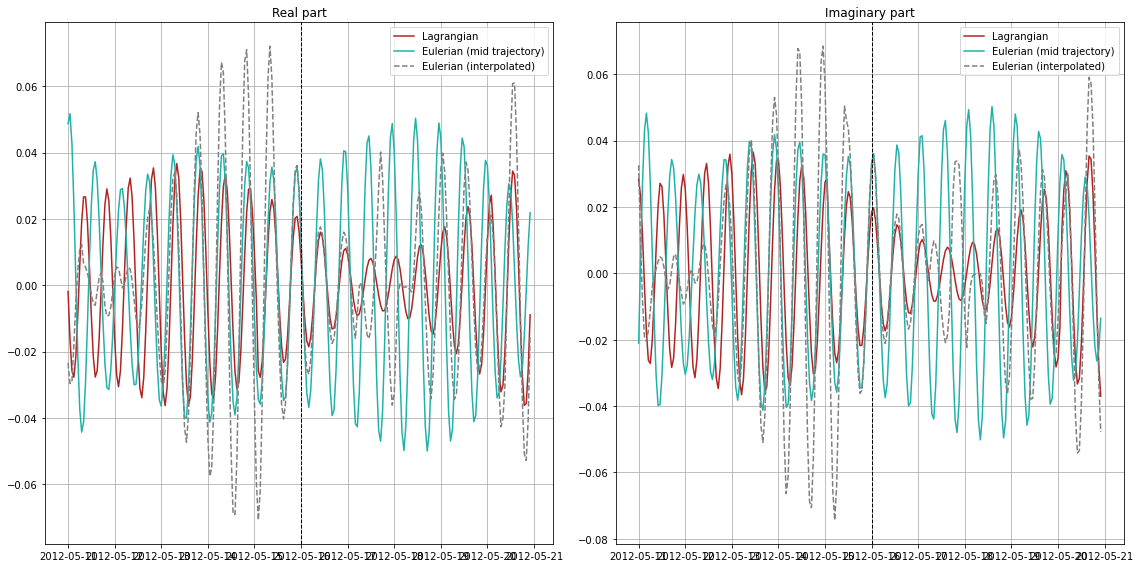

In [197]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(time[:-1],np.real(_df1.zonal_velocity_hat)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time[:-1],interp_mid2_hatr[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[0].plot(time[:-1],interp2_hatr[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[0].legend();ax[0].grid()
ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[0].set_title('Real part')

ax[1].plot(time[:-1],np.imag(_df1.zonal_velocity_hat)[:-1],c='firebrick',linestyle='-',label='Lagrangian')
ax[1].plot(time[:-1],interp_mid2_hati[:-1],c='lightseagreen',linestyle='-',label='Eulerian (mid trajectory)')
ax[1].plot(time[:-1],interp2_hati[:-1],c='grey',linestyle='--',label='Eulerian (interpolated)')
ax[1].legend();ax[1].grid()
ax[1].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].set_title('Imaginary part')
fig.tight_layout()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-84-c499af89b652>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


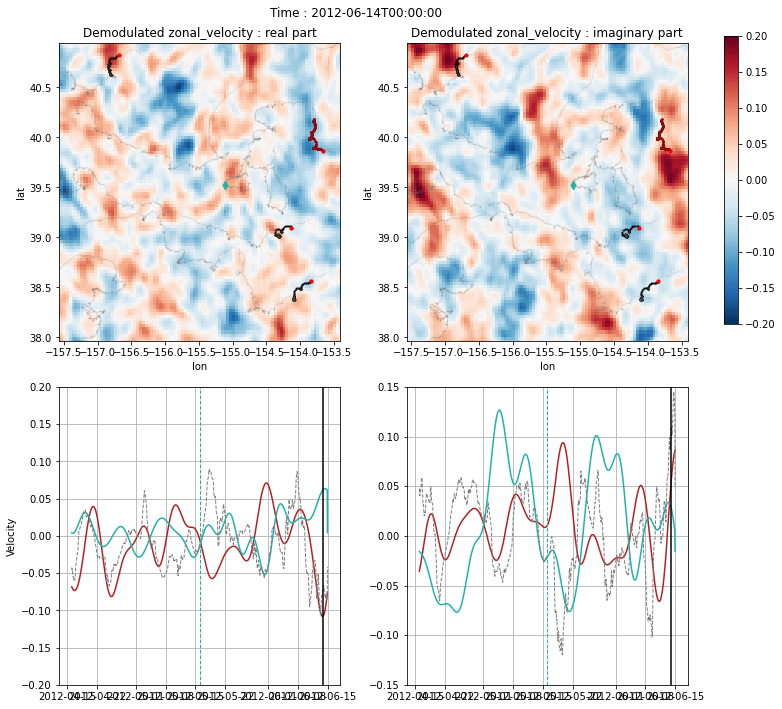

In [85]:
_df = [_df1,_df2,_df3,_df4,_df5,_df6]
gen_figs_flts_interp(_df,[interp_demodr,interp_demodi,interp_mid_demodr,interp_mid_demodi],30*24,'zonal_velocity',1/24,savefig=False
             )

In [86]:
IT = np.arange(0,dsi.time.size)
for it in IT:
    gen_figs_flts_interp(_df,[interp_demodr,interp_demodi,interp_mid_demodr,interp_mid_demodi],
                         it,'zonal_velocity',1/24,savefig=True
                        )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-84-c499af89b652>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarn

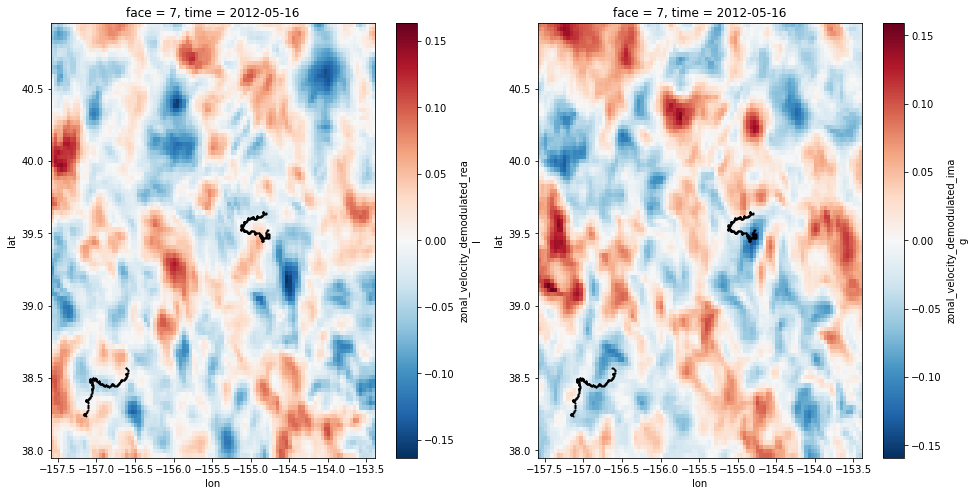

In [90]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
dsi.isel(time=time.size//2).zonal_velocity_demodulated_real.plot(ax=ax[0],x='lon',y='lat')
ax[0].scatter(dfi.lon,dfi.lat,s=1,c='k');ax[0].scatter(dfi_2.lon,dfi_2.lat,s=1,c='k')
dsi.isel(time=time.size//2).zonal_velocity_demodulated_imag.plot(ax=ax[1],x='lon',y='lat')
ax[1].scatter(dfi.lon,dfi.lat,s=1,c='k');ax[1].scatter(dfi_2.lon,dfi_2.lat,s=1,c='k')

In [207]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
